In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
def compute_image_derivative(image):
    
    '''
    Function to compute image derivative along x and y axis
    
    Input:
        image - H x W - input image
    Returns:
        list of image derivatives along x and y axis 
    '''
    
    image_x_filter = np.array([[ -1, 0, 1]])

    image_y_filter = np.array([[ -1],
                               [  0],
                               [  1]])

    image_x_derivative = cv2.filter2D(image, -1, image_x_filter)
    image_y_derivative = cv2.filter2D(image, -1, image_y_filter)
    
    return [image_x_derivative, image_y_derivative]
    
def compute_optical_flow(image_1, image_2, filter_size):
    
    '''
    Computes optical flow between two images
    
    Input:
        image_1 - H x W - input image 1
        image_2 - H x W - input image 2
        filter_size - tuple - filter size
        
    Returns:
        flow_matrix - H x W x 2 - matrix with flow vectors
        
    '''
    
    image_1_derivative = compute_image_derivative(image_1)
    image_2_derivative = compute_image_derivative(image_2)
    
    # dx^2
    image_x_derivative_square = image_1_derivative[0] * image_1_derivative[0]
    
    # dy^2
    image_y_derivative_square = image_1_derivative[1] * image_1_derivative[1]
    
    # dx*dy
    image_xy_derivative = image_1_derivative[0] * image_1_derivative[1]
    
    # dt 
    image_t_derivative = image_2 - image_1
    
    image_xt_derivative = image_1_derivative[0] * image_t_derivative
    image_yt_derivative = image_1_derivative[1] * image_t_derivative
    
    summation_filter = np.ones(filter_size) 
    
    
    # computing summation dx^2, dy^2, dx*dt, dy*dt, dx*dy
    image_xt_derivative_summation = cv2.filter2D(image_xt_derivative, -1, summation_filter)
    image_yt_derivative_summation = cv2.filter2D(image_yt_derivative, -1, summation_filter)
    image_x_derivative_square_summation = cv2.filter2D(image_x_derivative_square, -1, summation_filter)
    image_y_derivative_square_summation = cv2.filter2D(image_y_derivative_square, -1, summation_filter)
    image_xy_derivative_summation = cv2.filter2D(image_xy_derivative, -1, summation_filter)
    
    flow_matrix = np.zeros((image_1.shape[0], image_1.shape[1], 2))
    
    for i in range(image_1.shape[0]):
        
        for j in range(image_1.shape[1]):
            
            # computing matrix
            optical_flow_mat = np.array([[image_x_derivative_square_summation[i, j], image_xy_derivative_summation[i, j]], 
                                        [image_xy_derivative_summation[i, j], image_y_derivative_square_summation[i, j]]])
            # print(optical_flow_mat.shape)
            b = -np.array([[image_xt_derivative_summation[i, j]], [image_yt_derivative_summation[i, j]]])
            
            flow_vector = np.linalg.pinv(optical_flow_mat) @ b
            
            factor = np.sqrt(flow_vector[0]**2 + flow_vector[1]**2)
            if factor > 0.3:
                flow_matrix[i, j, :] = flow_vector.T 
                
            # print(flow_vector)
        # print(i)
    
    
    print('Optical flow computed')
    return flow_matrix

def plot_flow_image(image, flow_matrix):
    '''
    Plot flow vectors on image
    
    '''
    plt.imshow(image, 'gray')
    for i in range(0, flow_matrix.shape[0], 30):
        for j in range(0, flow_matrix.shape[1], 30):
            plt.quiver(j, i, flow_matrix[i, j, 0], flow_matrix[i, j, 1], scale = 10)
            
def normalize_image(image):
    '''
    Function to normalize image
    '''
    image = (image - np.mean(image)) /255
    
    return image
    

In [3]:
if __name__ == '__main__':
    
    dataset = './eval-data-gray'
    
    directory = '/Dumptruck'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    image_2 = cv2.imread(image_2_path)
    image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    

    image_1 = normalize_image(image_1)
    image_2 = normalize_image(image_2)
    
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    
    
    

Optical flow computed


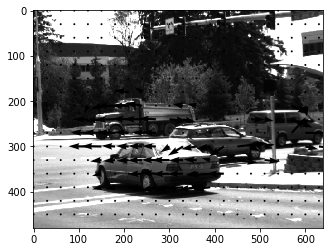

In [4]:
    plot_flow_image(image_1, flow_matrix)
    

In [5]:
    np.max(flow_matrix)

1.8176778334267094